In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Step 1: Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing import image
import os
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Step 2: Set parameters
img_height, img_width = 224, 224  # Dimensions for MobileNetV3
batch_size = 32
base_learning_rate = 0.001
epochs = 50

In [4]:
# Path to the folder you want to check
dataset_dir = '/content/drive/MyDrive/data/Dataset/Potato'

# Check if the folder exists
if os.path.exists(dataset_dir):
    print("Folder exists. Reading contents...")

    # List the contents of the folder
    folder_contents = os.listdir(dataset_dir)

    print("Contents of the folder:")
    for item in folder_contents:
        print(item)
else:
    print("Folder does not exist.")


Folder exists. Reading contents...
Contents of the folder:
Potato__early_blight
Potato__healthy
Potato__late_blight


Found 2351 files belonging to 3 classes.
Using 1881 files for training.
Found 2351 files belonging to 3 classes.
Using 470 files for validation.


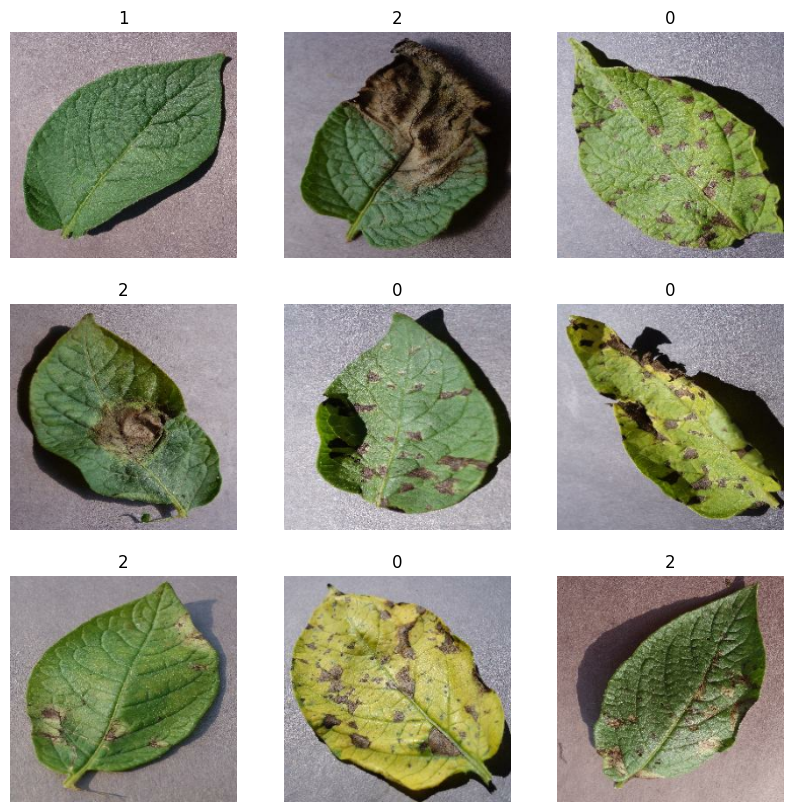

In [5]:
# Define the function to display a batch of images with their labels
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(9):
        ax = plt.subplot(3, 3, n + 1)
        plt.imshow(image_batch[n].numpy().astype("uint8"))
        plt.title(label_batch[n].numpy())
        plt.axis("off")
    plt.show()

# Load datasets (you already have this part)
train_dataset = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation_dataset = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Get a batch of images and labels from the training dataset
image_batch, label_batch = next(iter(train_dataset))

# Display the images and labels
show_batch(image_batch, label_batch)


In [6]:
# Assuming you have already loaded the train and validation datasets
print("Class indices in training data:")
for idx, class_name in enumerate(train_dataset.class_names):
    print(f"Class: {class_name}, Label: {idx}")

print("\nClass indices in validation data:")
for idx, class_name in enumerate(validation_dataset.class_names):
    print(f"Class: {class_name}, Label: {idx}")


Class indices in training data:
Class: Potato__early_blight, Label: 0
Class: Potato__healthy, Label: 1
Class: Potato__late_blight, Label: 2

Class indices in validation data:
Class: Potato__early_blight, Label: 0
Class: Potato__healthy, Label: 1
Class: Potato__late_blight, Label: 2


In [7]:
# Step 5: Prepare the dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
# Step 6: Build the model
base_model = MobileNetV3Small(input_shape=(img_height, img_width, 3),
                              include_top=False,
                              weights='imagenet')
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(3, activation='softmax')  # Number of classes dynamically set
])

4334752/4334752 [==============================] - 0s 0us/step


In [9]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [10]:
# Step 7: Compile the model
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
# Step 8: Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/50
59/59 [==============================] - 317s 5s/step - loss: 0.5610 - accuracy: 0.7852 - val_loss: 0.3285 - val_accuracy: 0.8979
Epoch 2/50
59/59 [==============================] - 11s 168ms/step - loss: 0.2613 - accuracy: 0.9314 - val_loss: 0.2184 - val_accuracy: 0.9404
Epoch 3/50
59/59 [==============================] - 9s 146ms/step - loss: 0.2003 - accuracy: 0.9458 - val_loss: 0.1858 - val_accuracy: 0.9426
Epoch 4/50
59/59 [==============================] - 11s 167ms/step - loss: 0.1728 - accuracy: 0.9522 - val_loss: 0.1619 - val_accuracy: 0.9489
Epoch 5/50
59/59 [==============================] - 11s 172ms/step - loss: 0.1531 - accuracy: 0.9548 - val_loss: 0.1507 - val_accuracy: 0.9489
Epoch 6/50
59/59 [==============================] - 11s 171ms/step - loss: 0.1388 - accuracy: 0.9580 - val_loss: 0.1493 - val_accuracy: 0.9511
Epoch 7/50
59/59 [==============================] - 11s 173ms/step - loss: 0.1287 - accuracy: 0.9612 - val_loss: 0.1311 - val_accuracy: 0.9553
Ep

In [12]:
# Step 9: Save the model
model.save('potato_disease_model.h5')

In [13]:
validation_dataset = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Get the class labels
class_labels = validation_dataset.class_names

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in validation_dataset:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


Found 2351 files belonging to 3 classes.
Using 470 files for validation.
1/1 [==============================] - 1s 804ms/step

Classification Report:
                      precision    recall  f1-score   support

Potato__early_blight       0.97      0.98      0.97       211
     Potato__healthy       0.97      0.91      0.94        34
 Potato__late_blight       0.97      0.96      0.97       225

            accuracy                           0.97       470
           macro avg       0.97      0.95      0.96       470
        weighted avg       0.97      0.97      0.97       470



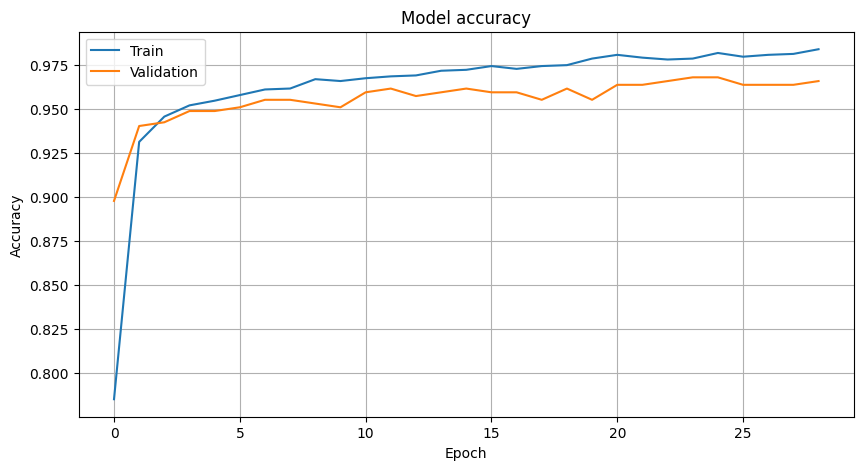

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()


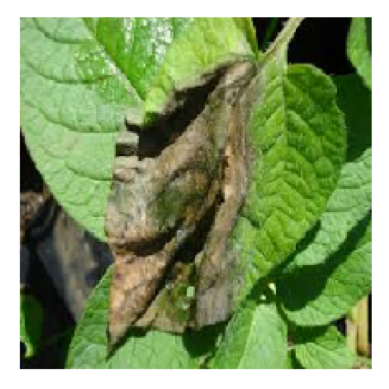

1/1 [==============================] - 4s 4s/step
Predicted Class: 2
Probabilities: tf.Tensor([0.3418237  0.23160636 0.42657   ], shape=(3,), dtype=float32)


In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load your pre-trained model
model = load_model('/content/potato_disease_model.h5')

# Function to preprocess and predict the class of an image
def predict_image(img_path, model):
    # Load the image
    img = image.load_img(img_path, target_size=(224, 224))  # Adjust target size based on your model's input size
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Convert the image to a numpy array
    img_array = image.img_to_array(img)

    # Expand dimensions to match the expected input format (batch size, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the image (e.g., scaling)
    img_array = preprocess_input(img_array)

    # Predict the class
    predictions = model.predict(img_array)

    # Apply softmax to get probabilities
    probabilities = tf.nn.softmax(predictions[0])

    # Get the class with the highest probability
    predicted_class = np.argmax(probabilities)

    return predicted_class, probabilities

# Example usage
img_path = '/content/class2.png'
predicted_class, probabilities = predict_image(img_path, model)

# Print the predicted class and probabilities
print(f'Predicted Class: {predicted_class}')
print('Probabilities:', probabilities)


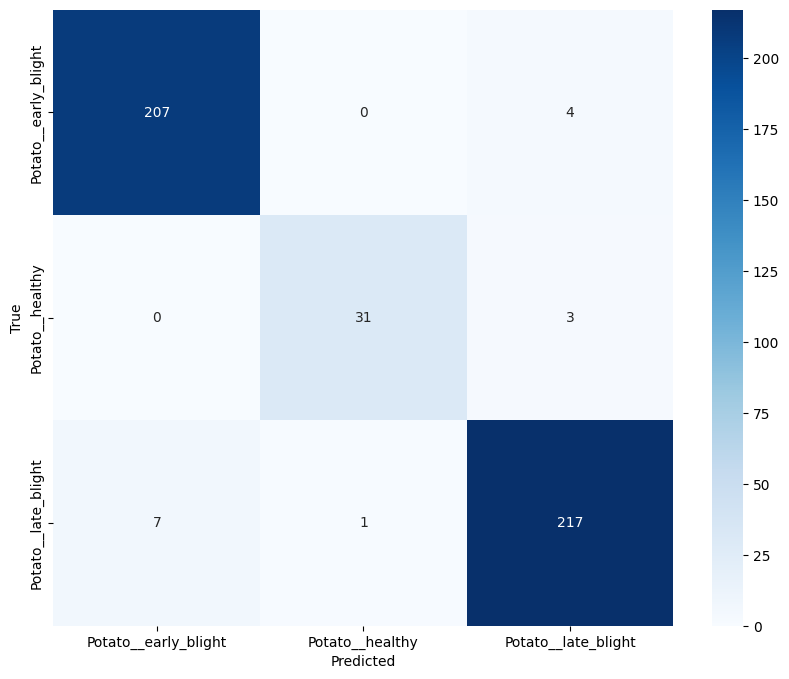

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [17]:
import tensorflow as tf
import numpy as np

# Load the Keras model from the .h5 file
h5_model_path = '/content/potato_disease_model.h5'
model = tf.keras.models.load_model(h5_model_path)

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
tflite_model_path = 'potatomodel.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f'TensorFlow Lite model saved to: {tflite_model_path}')

TensorFlow Lite model saved to: potatomodel.tflite


In [18]:
pip freeze > requirements.txt
